# Imports

In [6]:
#data munging
import pandas as pd
import numpy as np
import geopandas as gpd

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#text processing
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#API Connections
from sodapy import Socrata

#formatting & display options
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important; }</style>"))
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',900)
pd.set_option('display.max_colwidth',100)

[nltk_data] Downloading package stopwords to /Users/Alec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Alec/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Alec/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

In [7]:
#AirBnB Data for Los Angeles
#http://insideairbnb.com/los-angeles/?neighbourhood=&filterEntireHomes=false&filterHighlyAvailable=false&filterRecentReviews=false&filterMultiListings=false

df = pd.read_csv('listings_la.csv')
df = df[df['last_review'] > '2018-01-01']

In [8]:
#USC Crime data for Los Angeles
#https://usc.data.socrata.com/stories/s/mu6n-9gws/

# Tier 1 LA Crime Data - API Code
# https://dev.socrata.com/foundry/usc.data.socrata.com/qfdv-ru39
# Tier 2 LA Crime Data - API Code
# https://dev.socrata.com/foundry/usc.data.socrata.com/hfc5-9p65

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("usc.data.socrata.com", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(usc.data.socrata.com,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First limit = x results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results_1 = client.get("qfdv-ru39",limit = 16400)
results_2 = client.get("hfc5-9p65",limit = 10000)
# Convert to pandas DataFrame
crime_1_df = pd.DataFrame.from_records(results_1)
crime_2_df = pd.DataFrame.from_records(results_2)

In [9]:
def tokenize(text):
    """
    Tokenize text, take out stop words, lemmatize text 

    Input:
        text (str)

    Output:
        lemmed (list) : List of strings 
    """
    text = str(text)
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    words = word_tokenize(text)
    no_stop_words = [w for w in words if w not in stopwords.words("english")]
    lemmed_word_list = [WordNetLemmatizer().lemmatize(w).lower().strip() for w in no_stop_words]
    return lemmed_word_list

def get_common_words(nb_df):
    """
    Return a list of the common words in the airbnb titles grouped by the groupby series you input. 
    
    Input:
        nb_df (pandas.core.groupby.generic.SeriesGroupBy) : Groupby series. Group on categories you want to have word frequencies by.
        
    Output:
        df (dataframe) : list of words, frequencies, and category assigned. 
    """
    df_words = pd.DataFrame()
    df = pd.DataFrame()
    for nb_name in nb_df.groups.keys():
        tokenized_list = nb_df.get_group(nb_name).apply(lambda x:tokenize(x))
        
        for i in range(tokenized_list.shape[0]):
            df_append = pd.DataFrame(tokenized_list.iloc[i],columns=['words'])
            df_words = df_words.append(df_append)
        counts = df_words['words'].value_counts()
        word_count_df = pd.DataFrame(counts).reset_index().rename(mapper={'index':'word','words':'word count'},axis=1)
        word_count_df['Neighbourhood'] = nb_name
        df = df.append(word_count_df)
    return df

def apply_price_quantiles(q75,q50,q25,price):
    """
    Classify price into a percentile bucket
    
    Input:
        q75 (float) : 75th percentile cutoff number
        q50 (float) : 50th percentile cutoff number
        q25 (float) : 25th percentile cutoff number
        price (str) : price that we want to bucket by percentile
        
    Output:
        (str) description, 1 or 4 buckets to be classified into
    """
    price = float(price)
    if(q75<= price):
        return 'above 75th percentile'
    elif(q50 <= price):
        return '50th-75th percentile'
    elif(q25<= price):
        return '25th-50th percentile'
    else:
        return 'below 25th percentile'
    
def display_wordcloud(word_dict,max_words,add_stopwords = ['']):
    '''
    Prints wordcloud from given words and frequencies.
    
    Inputs:
        word_dict (dict) : key - words, val - frequencies word occurs
        max_words (int) : how many words for wordcloud to display
        add_stopwords (list): list of strings that you want to not display in wordcloud
    
    Output:
        Printed Wordcloud!
    '''
    assert isinstance(word_dict,dict)
    assert isinstance(max_words,int)
    assert isinstance(add_stopwords,list)
    
    stopwords = ["2","1","w","3","4","5","los","la","angeles","one"]
    stopwords.extend(add_stopwords)
    for i in stopwords:
        try:
            word_dict.pop(i)
        except:
            continue

    wordcloud = WordCloud(max_font_size=50,max_words=max_words,background_color="white",min_font_size = 6,width = 800,height = 600).fit_words(word_dict)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [10]:
#Calculate price quantiles

q75 = df['price'].quantile(.75)
q50 = df['price'].quantile(.50)
q25 = df['price'].quantile(.25)
df['Price Percentile'] = df[['price']].apply(lambda x:apply_price_quantiles(q75,q50,q25,x),axis=1)

In [11]:
words = df.groupby('neighbourhood')['name']
percentile = df.groupby('Price Percentile')['name']

In [12]:
#Note: This cell takes a bit to run. Has to parse through a ton of titles!

nb_words_df = get_common_words(words)
percentile_words_df = get_common_words(percentile)

In [13]:
#Check out the words in the titles of beverly hills

nb_words_df[nb_words_df['Neighbourhood'] == 'Beverly Hills'].head(30)

,word,word count,Neighbourhood
0,hill,448,Beverly Hills
1,beverly,448,Beverly Hills
2,private,370,Beverly Hills
3,room,328,Beverly Hills
4,home,266,Beverly Hills
5,house,244,Beverly Hills
6,bedroom,219,Beverly Hills
7,2,167,Beverly Hills
8,la,159,Beverly Hills
9,cozy,152,Beverly Hills


In [14]:
#Create dicts that contain the rankings of words by count in each percentile so that we can make wordclouds. 

p75_dict = dict(zip(list(percentile_words_df[percentile_words_df['Neighbourhood']=='above 75th percentile']['word']),list(percentile_words_df[percentile_words_df['Neighbourhood']=='above 75th percentile']['word count'])))
p50_dict = dict(zip(list(percentile_words_df[percentile_words_df['Neighbourhood']=='50th-75th percentile']['word']),list(percentile_words_df[percentile_words_df['Neighbourhood']=='50th-75th percentile']['word count'])))
p25_dict = dict(zip(list(percentile_words_df[percentile_words_df['Neighbourhood']=='25th-50th percentile']['word']),list(percentile_words_df[percentile_words_df['Neighbourhood']=='25th-50th percentile']['word count'])))
pless25_dict = dict(zip(list(percentile_words_df[percentile_words_df['Neighbourhood']=='below 25th percentile']['word']),list(percentile_words_df[percentile_words_df['Neighbourhood']=='below 25th percentile']['word count'])))

### Wordclouds per percentile

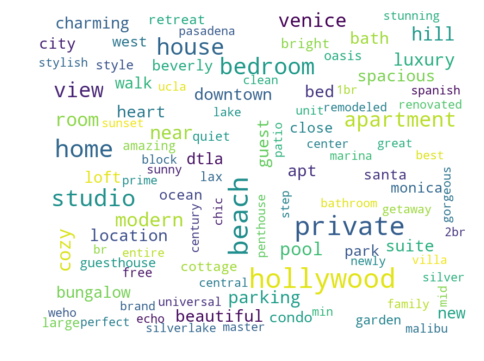

In [15]:
display_wordcloud(p75_dict,100)

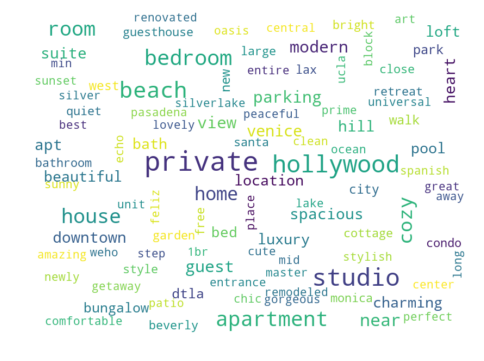

In [16]:
display_wordcloud(p50_dict,100)

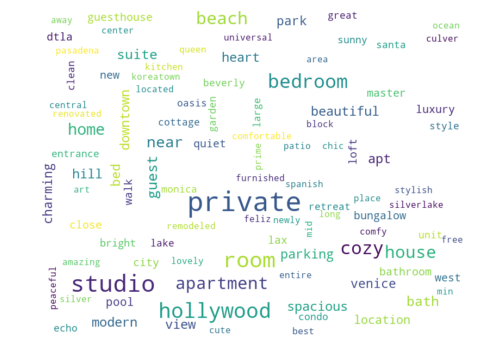

In [17]:
display_wordcloud(p25_dict,100)

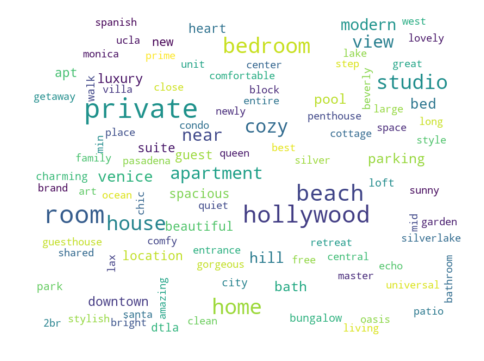

In [18]:
display_wordcloud(pless25_dict,100)

In [19]:
#Look into the parts of speech that make up the most common words

df_p75 = pd.Series(p75_dict).to_frame().reset_index().rename(mapper = {'index':'word',0:'count'},axis=1)
df_pless25 = pd.Series(pless25_dict).to_frame().reset_index().rename(mapper = {'index':'word',0:'count'},axis=1)

df_p75 = df_p75.head(100)
df_pless25 = df_pless25.head(100)

df_p75['POS Tup'] = df_p75[['word']].apply(nltk.pos_tag)
df_pless25['POS Tup'] = df_pless25[['word']].apply(nltk.pos_tag)

df_p75[['Wordd','POS']] = pd.DataFrame(df_p75['POS Tup'].to_list(),index = df_p75.index)
df_pless25[['Wordd','POS']] = pd.DataFrame(df_pless25['POS Tup'].to_list(),index = df_pless25.index)

In [20]:
df_pless25['POS'].value_counts()

NN     47
JJ     29
RB      8
VBD     3
VBG     3
IN      3
JJS     3
VBP     2
CD      1
VBN     1
Name: POS, dtype: int64

In [21]:
df_p75['POS'].value_counts()

NN     46
JJ     28
VBP     4
VBD     4
RB      3
NNS     3
VBG     3
CD      2
VBN     2
IN      2
JJS     2
RBS     1
Name: POS, dtype: int64

In [22]:
#What are the most common adjectives in the top and bottom percentiles?

df_p75.loc[df_p75['POS'] == 'JJ']

,word,count,POS Tup,Wordd,POS
2,private,3084,"(private, JJ)",private,JJ
9,modern,1594,"(modern, JJ)",modern,JJ
15,pool,1363,"(pool, JJ)",pool,JJ
18,apt,1058,"(apt, JJ)",apt,JJ
20,spacious,1029,"(spacious, JJ)",spacious,JJ
22,suite,1002,"(suite, JJ)",suite,JJ
23,beautiful,999,"(beautiful, JJ)",beautiful,JJ
28,loft,879,"(loft, JJ)",loft,JJ
29,new,855,"(new, JJ)",new,JJ
32,bungalow,811,"(bungalow, JJ)",bungalow,JJ


In [23]:
df_pless25.loc[df_pless25['POS'] == 'JJ']

,word,count,POS Tup,Wordd,POS
0,private,5444,"(private, JJ)",private,JJ
8,cozy,2394,"(cozy, JJ)",cozy,JJ
12,modern,1813,"(modern, JJ)",modern,JJ
18,bath,1457,"(bath, JJ)",bath,JJ
21,suite,1236,"(suite, JJ)",suite,JJ
22,beautiful,1234,"(beautiful, JJ)",beautiful,JJ
24,spacious,1233,"(spacious, JJ)",spacious,JJ
27,apt,1140,"(apt, JJ)",apt,JJ
28,new,1055,"(new, JJ)",new,JJ
36,close,809,"(close, JJ)",close,JJ


## Geo-Visualization of LA Airbnb price and crime data

### Load Data

In [ ]:
la_geo = gpd.read_file('neighbourhoods.geojson')

#Read in all of LA Census data
#Property/Violent Crimes is at the Tract level, but we need to aggregate up to the neighborhood level to compare with the Airbnb data. In order to aggregate properly, I need to know how to weight 
#each tracts crime count.

df_la = pd.read_csv('Citizen_Connect_Variables__LA_.csv')

In [ ]:
#Calculate the median home price per Neighborhood in LA from the Airbnb data

n_price = df.groupby('neighbourhood')['price'].median()
n_count = df.groupby('neighbourhood')['price'].count()
n_price = n_price.to_frame().reset_index()
nb_df = n_price.merge(n_count.to_frame(),how='left',on ='neighbourhood')

In [ ]:
def crime_to_neighborhood(df_crime,df_census,crime_type,year = '2016'):
    '''
    Pull in crime and LA Census data. SInce the granularity is at the tract level, we need to aggregate the measures up to the neighborhood level in order to compare with Airbnb data.
    Find the total population in the neighborhood and calculate each tracts % of population. Then use this value weight the crime rate data to then aggregate to the neighborhood level. 
    
    Input:
        df_crime (df) : Crime data from USC database
        df_census (df) : Data from LA Census
        crime_type (string) : Name the type of crime
        year (str) ('2016') : Select which year you want to get data from 
    Ouput:
        df (dataframe) : Neighborhood and crime rates
    
    '''
    df_crime = df_crime.loc[(df_crime['year']== year)&(df_crime['variable']==crime_type)]
    df_crime['tract_number'] = df_crime['tract_number'].astype(float)
    
    #Pull populationd data from full census data & join to crime data
    df_census = df_census.loc[(df_census['Policy Area'] == 'Demography')&(df_census['Variable'] == 'Total Population')&(df_census['Date']== '01/01/'+year)]
    df_combined = df_crime.merge(df_census,how ='left',left_on=['tract_number'],right_on = ['Tract'])
    
    #drop any null 
    df_combined = df_combined.loc[~df_combined['Value'].isna()]
    
    #Get total population data by neighborhood
    population_df = df_combined.groupby('Neighborhood')['Value'].sum().to_frame().reset_index().rename(mapper={'Value':'Total N Population'},axis=1)
    df_combined = df_combined.merge(population_df,how='left',on='Neighborhood')
    
    #Find the tracts percent of pop data
    df_combined['Tract Perc of Pop'] = df_combined['Value']/df_combined['Total N Population']
    df_combined['count'] = df_combined['count'].astype(float)
    
    #adjust the tract crime rate per 1000 people so we can aggregate to a 
    df_combined[crime_type] = df_combined['count'] * df_combined['Tract Perc of Pop']
    
    df = df_combined.groupby('neighborhood')[crime_type].sum().to_frame().reset_index()
    return df,population_df

In [ ]:
violent_df,population_df = crime_to_neighborhood(crime_1_df,df_la,'Part I Violent Crimes')

In [ ]:
property_crime_df,population_df_2 = crime_to_neighborhood(crime_1_df,df_la,'Part I Property Crimes')

In [ ]:
crime2_df,population_df_3 = crime_to_neighborhood(crime_2_df,df_la,'Part II Crimes')

In [ ]:
#merge all the data toghether by neighborhood. Drop neighborhoods where we lack data (nulls)
corr_df = n_price.merge(violent_df,how = 'outer',left_on=['neighbourhood'],right_on = ['neighborhood']).dropna()
corr_df = corr_df.merge(property_crime_df,how = 'outer',left_on=['neighbourhood'],right_on = ['neighborhood']).dropna()
corr_df = corr_df.merge(population_df,how = 'outer',left_on=['neighbourhood'],right_on = ['Neighborhood']).dropna()
corr_df = corr_df.merge(crime2_df,how = 'outer',left_on=['neighbourhood'],right_on = ['neighborhood']).dropna()
corr_df = corr_df.drop(['neighborhood_x','neighborhood_y','neighborhood','Neighborhood'],axis=1)

In [ ]:
corr_df.corr()

In [ ]:
sns.pairplot(corr_df)

In [ ]:
#Log transform data because all our values are heavily skewed towards 0. 
corr_df['price'] = corr_df.price.apply(np.log)
corr_df['Part I Violent Crimes'] = corr_df['Part I Violent Crimes'].apply(lambda x:np.log(x+1))
corr_df['Part I Property Crimes'] = corr_df['Part I Property Crimes'].apply(lambda x:np.log(x+1))
corr_df['Part II Crimes'] = corr_df['Part II Crimes'].apply(lambda x:np.log(x+1))
corr_df['Total N Population'] = corr_df['Total N Population'].apply(np.log)

In [ ]:
sns.set(style="ticks")

In [ ]:
sns.pairplot(corr_df)

In [ ]:
corr_df.corr()

In [ ]:
corr_df.head()

### Visualize LA Census & Airbnb data

In [ ]:
la_neighborhoods = 'neighbourhoods.geojson'

In [ ]:
map1 = folium.Map(
        location=[34.05, -118.24],
        tiles = 'Stamen Toner'
)

folium.GeoJson(
    la_geo,
    name = 'geojson'
).add_to(map1)

folium.LayerControl().add_to(map1)

map1.save('map.html')

In [ ]:
map2 = folium.Map(
        location=[34.05, -118.24],
        tiles = 'Stamen Toner')

folium.Choropleth(
    geo_data=la_neighborhoods,
    name='choropleth',
    data=n_price,
    columns=['neighbourhood', 'price'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Median AirBnB List Price'
).add_to(map2)

folium.LayerControl().add_to(map2)

map2.save('map2.html')

In [ ]:
map3 = folium.Map(
        location=[34.05, -118.24])

folium.Choropleth(
    geo_data=la_neighborhoods,
    name='Part I Violent Crimes',
    data=corr_df,
    columns=['neighbourhood', 'Part I Violent Crimes'],
    key_on='feature.properties.neighbourhood',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Part I Violent Crimes'
).add_to(map3)

folium.Choropleth(
    geo_data=la_neighborhoods,
    name='Part I Property Crimes',
    data=corr_df,
    columns=['neighbourhood', 'Part I Property Crimes'],
    key_on='feature.properties.neighbourhood',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Part I Property Crimes'
).add_to(map3)

folium.Choropleth(
    geo_data=la_neighborhoods,
    name='Part II Crimes',
    data=corr_df,
    columns=['neighbourhood', 'Part II Crimes'],
    key_on='feature.properties.neighbourhood',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Part II Crimes'
).add_to(map3)

folium.Choropleth(
    geo_data=la_neighborhoods,
    name='Median Airbnb Price',
    data=corr_df,
    columns=['neighbourhood', 'price'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Part II Crimes'
).add_to(map3)

folium.Choropleth(
    geo_data=la_neighborhoods,
    name='Population',
    data=corr_df,
    columns=['neighbourhood', 'Total N Population'],
    key_on='feature.properties.neighbourhood',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Population'
).add_to(map3)


folium.LayerControl().add_to(map3)

map3.save('map3.html')